In [1]:
# install library
!pip install openpyxl
# !pip install pqkmeans

# faiss library (CPU & GPU)
# !apt install libomp-dev
# !pip install faiss-cpu
# !python -m pip install --upgrade faiss faiss-gpu

In [2]:
# import library
# import faiss
# import pqkmeans
import time
import numpy as np
import pandas as pd
import datetime as dt
import warnings
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import plotly.express as px
import seaborn as sns
import plotly.graph_objs as go
import sklearn.preprocessing as pp

from plotly.offline import init_notebook_mode, iplot
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.datasets import make_blobs
from sklearn.preprocessing import MinMaxScaler,StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans, MiniBatchKMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from IPython.core.pylabtools import figsize
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display
from ipywidgets import widgets, HBox
from sklearn.metrics import silhouette_score
from sklearn.manifold import MDS
from plotly.subplots import make_subplots
from mlxtend.plotting import plot_learning_curves
from mlxtend.data import mnist_data
from mlxtend.preprocessing import shuffle_arrays_unison

In [3]:
# prevent colab delete data.xlsx when logout
# tutorial video (https://video.twimg.com/tweet_video/EQbtltjVAAA2qTs.mp4)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# check path xlsx files
import os
import numpy as np
import pandas as pd
for dirname, _, filenames in os.walk('/content/drive/MyDrive'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# result : /content/drive/MyDrive/online_retail_II.xlsx

In [5]:
# set options
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [6]:
# set warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [7]:
# load data from xlsx files
df_ = pd.read_excel('/content/drive/MyDrive/online_retail_II.xlsx', sheet_name='Year 2009-2010', engine='openpyxl')
df = df_.copy()
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95000,13085.00000,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75000,13085.00000,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75000,13085.00000,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10000,13085.00000,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25000,13085.00000,United Kingdom


In [8]:
# exploratory data
def check_df(dataframe):
  print('===================================== Shape =====================================')
  print(dataframe.shape)
  print('===================================== Types =====================================')
  print(dataframe.dtypes)
  print('===================================== Head =====================================')
  print(dataframe.head(5))
  print('===================================== Tail =====================================')
  print(dataframe.tail(5))
  print('===================================== NA =====================================')
  print(dataframe.isnull().sum())
  print('===================================== Quantiles =====================================')
  print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [9]:
# run function check_df
check_df(df)

===================================== Shape =====================================
(525461, 8)
===================================== Types =====================================
Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object
===================================== Head =====================================
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate   Price  Customer ID         Country  
0 2009-

In [10]:
# result :
# + Customer ID is duplicated
# + Customer ID and Description have null values
# + Customer ID will be used for identifying customers on customer segmentation, so null values is both variables will be dropped
# + Price and Quantity variables have values below zero, which is not possible
# + Prices range from 0 to 25111

In [11]:
# begin cleaning data
# check null or empty data
df.isnull().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

In [12]:
# drop all null values
df.dropna(inplace=True)
df = df.dropna(subset=['Customer ID'])

In [13]:
# check again null data. we won't be using description information for segmentation so we'll leave them as is
df.isnull().sum().sum()

0

In [14]:
# check duplicate data
df.duplicated().sum()

6771

In [15]:
# drop all dupticate data
df = df.drop_duplicates()

In [16]:
# check again duplicate data for sure it is removed
df.duplicated().sum()

0

In [17]:
# overall about of data
df.describe()

,Quantity,Price,Customer ID
count,410763.00000,410763.00000,410763.00000
mean,12.92373,3.90836,15353.62186
std,102.03955,71.71479,1681.65767
min,-9360.00000,0.00000,12346.00000
25%,2.00000,1.25000,13979.00000
50%,5.00000,1.95000,15311.00000
75%,12.00000,3.75000,16797.00000
max,19152.00000,25111.09000,18287.00000


In [18]:
# check 1 randomly picked customer's shopping history
df.loc[df['Customer ID'] == 13085.00000]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95000,13085.00000,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75000,13085.00000,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75000,13085.00000,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10000,13085.00000,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25000,13085.00000,United Kingdom
...,...,...,...,...,...,...,...,...
74409,496166,79323W,WHITE CHERRY LIGHTS,8,2010-01-29 11:42:00,6.75000,13085.00000,United Kingdom
74410,496166,21137,BLACK RECORD COVER FRAME,8,2010-01-29 11:42:00,3.75000,13085.00000,United Kingdom
74411,496166,22041,"RECORD FRAME 7"" SINGLE SIZE",6,2010-01-29 11:42:00,2.55000,13085.00000,United Kingdom
74412,496166,40046A,RED DAISY PAPER LAMPSHADE,12,2010-01-29 11:42:00,1.25000,13085.00000,United Kingdom


In [19]:
# when a customer makes a purchase, the Invoice is duplicated and each unique item that has been purchased are transformed into seperate observations
# check number of unique customers
df['Customer ID'].nunique()

4383

In [20]:
# which countries are the customers from
countries = df['Country'].value_counts()
countries

United Kingdom          372705
EIRE                      8705
Germany                   8120
France                    5692
Netherlands               2768
Spain                     1271
Switzerland               1187
Belgium                   1053
Portugal                  1023
Channel Islands            906
Sweden                     882
Italy                      729
Australia                  654
Cyprus                     546
Austria                    537
Greece                     517
Denmark                    428
Norway                     369
Finland                    354
United Arab Emirates       318
Unspecified                280
USA                        244
Japan                      224
Poland                     194
Malta                      172
Lithuania                  154
Singapore                  117
Canada                      77
Thailand                    76
Israel                      74
Iceland                     71
RSA                         65
Korea   

In [21]:
# simple map of countries
data_map = dict(type='choropleth', locations = countries.index, locationmode = 'country names', z = countries, text = countries.index, colorbar = {'title':'Row nb.'}, colorscale=[[0, 'rgb(224,255,255)'], [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'], [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'], [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'], [1, 'rgb(227,26,28)']], reversescale = False)
layout = dict(autosize=False, width=1000, height=600,title='Number of rows per country', geo=dict(showframe=True, projection={'type':'mercator'}))

map_of_countries = go.Figure(data=[data_map],layout=layout)
iplot(map_of_countries, validate=False)

In [22]:
# percentage customers from UK and Outside UK
x = df['Country'].apply(lambda x: x if x == 'United Kingdom' else 'Not United Kingdom').value_counts().rename('Total Rows')
y = (x/df.shape[0]).rename('% Rows')
pd.concat([x, y], axis= 1)

,Total Rows,% Rows
United Kingdom,372705,0.90735
Not United Kingdom,38058,0.09265


In [23]:
# customers without country information
df.loc[df['Country'] == 'Unspecified', 'Customer ID'].value_counts()

16320.00000    187
14265.00000     48
12470.00000     23
12351.00000     21
15357.00000      1
Name: Customer ID, dtype: int64

In [24]:
# create array for 5 customers missing country information
missing_country = [16320.00000, 14265.00000, 12470.00000, 12351.00000, 15357.00000]
df.loc[df['Customer ID'].isin(missing_country)].head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
61394,494860,84832,ZINC WILLIE WINKIE CANDLE STICK,5,2010-01-19 11:01:00,0.85000,12470.00000,Unspecified
61395,494860,84836,ZINC METAL HEART DECORATION,5,2010-01-19 11:01:00,1.25000,12470.00000,Unspecified
61396,494860,85014D,PINK/BROWN DOTS RUFFLED UMBRELLA,1,2010-01-19 11:01:00,5.95000,12470.00000,Unspecified
61397,494860,85014A,BLACK/BLUE DOTS RUFFLED UMBRELLA,1,2010-01-19 11:01:00,5.95000,12470.00000,Unspecified
61398,494860,85014B,RED/WHITE DOTS RUFFLED UMBRELLA,2,2010-01-19 11:01:00,5.95000,12470.00000,Unspecified


In [25]:
# we won't be using Country information for segmentation so we'll leave them as is

In [26]:
# do each StockCode belong to a specific Item because 1 StockCode have many Descriptions
df.groupby('StockCode').agg({'Description' : 'nunique'}).sort_values(by='Description', ascending=False).head()

,Description
StockCode,
22345,4
22346,4
22384,4
20685,4
21955,4


In [27]:
# check all descriptions of 1 randomly StockCode
df.loc[df['StockCode'] == 22384, 'Description'].unique() 

array(['LUNCHBAG PINK RETROSPOT', 'LUNCH BAG PINK RETROSPOT',
       'LUNCH BAG PINK POLKADOT', 'LUNCH BAG PINK POLKADOTS'],
      dtype=object)

In [28]:
# 4 item names above refer to the same item and StockCode. This duplicate may be due to manual entry. StockCode is a better variable to analyze items because it's unique

In [29]:
# check the observations that have negative value for Quantity
df.loc[df['Quantity'] < 0].head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95000,16321.00000,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65000,16321.00000,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25000,16321.00000,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10000,16321.00000,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95000,16321.00000,Australia
183,C489449,21871,SAVE THE PLANET MUG,-12,2009-12-01 10:33:00,1.25000,16321.00000,Australia
184,C489449,84946,ANTIQUE SILVER TEA GLASS ETCHED,-12,2009-12-01 10:33:00,1.25000,16321.00000,Australia
185,C489449,84970S,HANGING HEART ZINC T-LIGHT HOLDER,-24,2009-12-01 10:33:00,0.85000,16321.00000,Australia
186,C489449,22090,PAPER BUNTING RETRO SPOTS,-12,2009-12-01 10:33:00,2.95000,16321.00000,Australia
196,C489459,90200A,PURPLE SWEETHEART BRACELET,-3,2009-12-01 10:44:00,4.25000,17592.00000,United Kingdom


In [30]:
# check the Invoices that starts with the letter "C"
df.loc[df['Invoice'].str.startswith('C', na=False), ['Quantity', 'Price']].describe()

,Quantity,Price
count,9816.00000,9816.00000
mean,-21.58272,28.53000
std,212.32439,405.51421
min,-9360.00000,0.01000
25%,-6.00000,1.56500
50%,-2.00000,2.95000
75%,-1.00000,6.75000
max,-1.00000,25111.09000


In [31]:
# invoices that start with "C" are refunds, the Quantity values are below 0

In [32]:
# remove refund invoices
df = df[~df['Invoice'].str.contains('C', na=False)]
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,400947.00000,13.76852,97.63982,1.00000,2.00000,5.00000,12.00000,19152.00000
Price,400947.00000,3.30557,35.04638,0.00000,1.25000,1.95000,3.75000,10953.50000
Customer ID,400947.00000,15361.45464,1680.66949,12346.00000,13985.00000,15311.00000,16805.00000,18287.00000


In [33]:
# some transaction have a sale price of zero, these could be free gifts for some customers and not true sales transaction. So, we will drop them.
indx = df.loc[df['Price'] == 0].index
df.drop(index= indx, inplace= True)

In [34]:
# create heatmap for cohort analysis
df_heat = df.copy()
print(df_heat.shape)

(400916, 8)


In [35]:
# for cohort analysis, there are a few labels that we have to create :
# + invoice period : a string representation of the year and month of a single transaction/invoice.
# + cohort group : a string representation of the the year and month of a customer’s first purchase. This label is common across all invoices for a particular customer.
# + cohort period / cohort index : a integer representation a customer’s stage in its “lifetime”. The number represents the number of months passed since the first purchase.

In [36]:
# data for heatmap
# data cointains from 2009/12/01 to 2010/12/09
def get_month(x):
  return dt.datetime(x.year, x.month, 1)

df_heat['InvoiceMonth'] = df_heat['InvoiceDate'].apply(get_month)
grouping = df_heat.groupby('Customer ID')['InvoiceMonth']
df_heat['CohortMonth'] = grouping.transform('min')
df_heat.tail()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,InvoiceMonth,CohortMonth
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95000,17530.00000,United Kingdom,2010-12-01,2009-12-01
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75000,17530.00000,United Kingdom,2010-12-01,2009-12-01
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75000,17530.00000,United Kingdom,2010-12-01,2009-12-01
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75000,17530.00000,United Kingdom,2010-12-01,2009-12-01
525460,538171,21931,JUMBO STORAGE BAG SUKI,2,2010-12-09 20:01:00,1.95000,17530.00000,United Kingdom,2010-12-01,2009-12-01


In [37]:
# get year, month, day and calculate cohort index
def get_month_int(dframe, column):
  years = dframe[column].dt.year
  months = dframe[column].dt.month
  days = dframe[column].dt.day
  return years, months, days

invoice_year, invoice_month,_ = get_month_int(df_heat, 'InvoiceMonth')
cohort_year, cohort_month,_ = get_month_int(df_heat, 'CohortMonth')

year_diff = invoice_year - cohort_year
month_diff = invoice_month - cohort_month

df_heat['CohortIndex'] = year_diff * 12 + month_diff + 1

In [38]:
# count monthly active customers from each cohort
grouping = df_heat.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['Customer ID'].apply(pd.Series.nunique)

# return number of unique elements in the object
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index= 'CohortMonth', columns= 'CohortIndex', values= 'Customer ID')
print(cohort_counts)

CohortIndex        1         2         3         4         5         6   \
CohortMonth                                                               
2009-12-01  955.00000 337.00000 319.00000 406.00000 363.00000 343.00000   
2010-01-01  383.00000  79.00000 119.00000 117.00000 101.00000 115.00000   
2010-02-01  374.00000  89.00000  84.00000 109.00000  92.00000  75.00000   
2010-03-01  443.00000  84.00000 102.00000 107.00000 103.00000  90.00000   
2010-04-01  294.00000  57.00000  57.00000  48.00000  54.00000  66.00000   
2010-05-01  254.00000  40.00000  43.00000  44.00000  45.00000  65.00000   
2010-06-01  270.00000  47.00000  51.00000  55.00000  62.00000  77.00000   
2010-07-01  186.00000  29.00000  34.00000  55.00000  54.00000  19.00000   
2010-08-01  162.00000  33.00000  48.00000  52.00000  19.00000       NaN   
2010-09-01  243.00000  55.00000  57.00000  24.00000       NaN       NaN   
2010-10-01  377.00000  97.00000  35.00000       NaN       NaN       NaN   
2010-11-01  325.00000  35

In [39]:
# customer retention is a very useful metric to understand how many of the all customers are still active.
# retention gives you the percentage of active customers compared to the total number of customers.

In [40]:
# create retention rate table
# get column 0 as a SERIES of shape (n,) (cohort sizes)
cohort_size = cohort_counts.iloc[:,0]
# axis=0 to ensure the divide along the row axis
retention = cohort_counts.divide(cohort_size, axis= 0)
# to show the number as percentage
retention.round(3) * 100

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2009-12-01,100.00000,35.30000,33.40000,42.50000,38.00000,35.90000,37.70000,34.20000,33.60000,36.20000,42.20000,49.50000,24.80000
2010-01-01,100.00000,20.60000,31.10000,30.50000,26.40000,30.00000,25.80000,23.00000,27.90000,31.90000,30.30000,9.90000,NaN
2010-02-01,100.00000,23.80000,22.50000,29.10000,24.60000,20.10000,19.30000,28.60000,25.40000,27.50000,7.20000,NaN,NaN
2010-03-01,100.00000,19.00000,23.00000,24.20000,23.30000,20.30000,24.60000,30.20000,27.50000,7.90000,NaN,NaN,NaN
2010-04-01,100.00000,19.40000,19.40000,16.30000,18.40000,22.40000,27.60000,26.20000,6.80000,NaN,NaN,NaN,NaN
2010-05-01,100.00000,15.70000,16.90000,17.30000,17.70000,25.60000,21.30000,7.90000,NaN,NaN,NaN,NaN,NaN
2010-06-01,100.00000,17.40000,18.90000,20.40000,23.00000,28.50000,6.70000,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-01,100.00000,15.60000,18.30000,29.60000,29.00000,10.20000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08-01,100.00000,20.40000,29.60000,32.10000,11.70000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


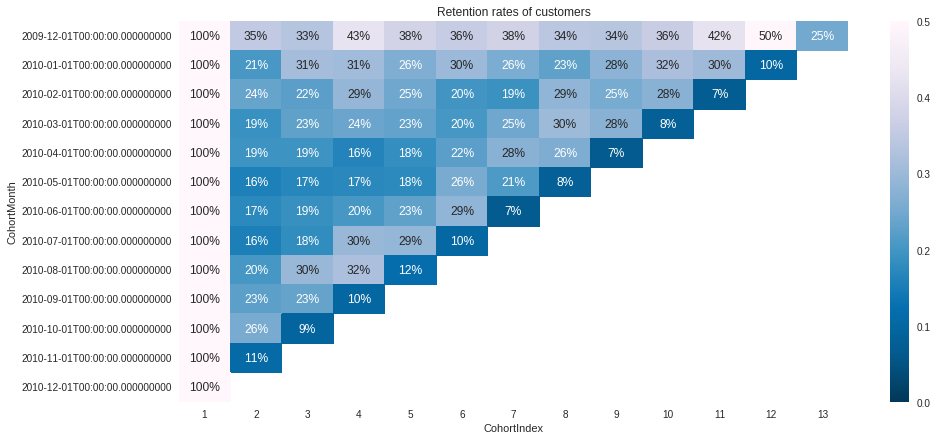

In [41]:
# build a heatmap for retension rates of customers
plt.figure(figsize=(15, 7))
plt.title('Retention rates of customers')
sns.heatmap(data=retention, annot=True, fmt= '.0%', vmin= 0.0, vmax= 0.5, cmap='PuBu_r')
plt.show()

In [42]:
# average quantity for each cohort
grouping = df_heat.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['Quantity'].mean()
cohort_data = cohort_data.reset_index()
average_quantity = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='Quantity')
average_quantity.round(1)
average_quantity.index = average_quantity.index.date

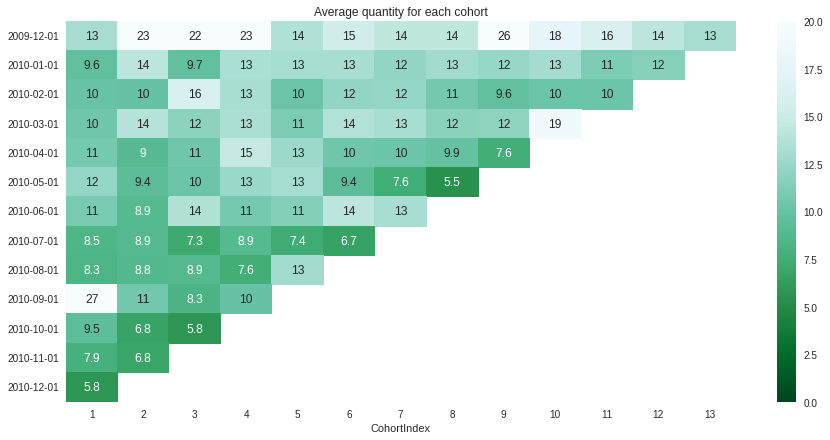

In [43]:
# build the heat map for average quantity
plt.figure(figsize=(15, 7))
plt.title('Average quantity for each cohort')
sns.heatmap(data=average_quantity, annot= True, vmin= 0.0, vmax= 20, cmap='BuGn_r')
plt.show()

In [44]:
# create a new variable by multiplying the price per unit with Quantity
df['TotalPrice'] = df['Quantity'] * df['Price']
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95000,13085.00000,United Kingdom,83.40000
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75000,13085.00000,United Kingdom,81.00000
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75000,13085.00000,United Kingdom,81.00000
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10000,13085.00000,United Kingdom,100.80000
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25000,13085.00000,United Kingdom,30.00000


In [45]:
# RFM Metrics
# + R : Recency shows how recent the customer has purchased. So that is the duration between today and the last date that the customer has purchased. Today will be the last date within the dataset.
# + F : Frequency shows how frequent the customer purchases. So the number of unique Invoices will be the number of times that he/she purchased.
# + M : Monetary shows the total amount of money that the customer has spent.

In [46]:
# check min and max invoice date
print('Min Invoice Date:', df.InvoiceDate.dt.date.min(), '\nMax Invoice Date:', df.InvoiceDate.dt.date.max())

Min Invoice Date: 2009-12-01 
Max Invoice Date: 2010-12-09


In [47]:
# 2 days will be added to "today's date" to eliminate the local time differences between stores and to make sure that Recency is always above 0
today_date = df['InvoiceDate'].max() + dt.timedelta(days=2)
today_date

Timestamp('2010-12-11 20:01:00')

In [48]:
rfm = df.groupby('Customer ID').agg({'InvoiceDate': lambda date: (today_date - date.max()).days, 'Invoice': lambda inv: inv.nunique(), 'TotalPrice': lambda price: price.sum()})
rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.00000,166,11,372.86000
12347.00000,4,2,1323.32000
12348.00000,75,1,222.16000
12349.00000,44,3,2671.14000
12351.00000,12,1,300.93000


In [49]:
# we will rate "Recency" customer who have been active more recently better than the less recent customer, because each company wants its customers to be recent
# we will rate "Frequency" and "Monetary Value" higher label because we want Customer to spend more money and visit more often(that is different order than recency).
# building RFM segments
# range(start, stop, step)
rfm_seg = rfm.copy()

r_labels = range(4, 0, -1)
f_labels = range(1, 5)
m_labels = range(1, 5)
r_quartiles = pd.qcut(rfm_seg['Recency'], q=4, labels= r_labels)
# f_quartiles = pd.qcut(rfm_seg['Frequency'], q=4, labels= f_labels)
m_quartiles = pd.qcut(rfm_seg['Monetary'], q=4, labels= m_labels)
# rfm_seg = rfm_seg.assign(R= r_quartiles, F= f_quartiles, M= m_quartiles)

# frequency is duplicated, solution : https://stackoverflow.com/questions/36880490/why-use-pandas-qcut-return-valueerror-bin-edges-must-be-unique/
def pct_rank_qcut(series, n):
    edges = pd.Series([float(i) / n for i in range(n + 1)])
    f = lambda x: (edges >= x).values.argmax()
    return series.rank(pct=1).apply(f)
f_quartiles = rfm_seg['Frequency'].astype(float)
f_quartiles = pct_rank_qcut(rfm_seg['Frequency'], 4)
rfm_seg = rfm_seg.assign(R= r_quartiles, F= f_quartiles, M= m_quartiles)

# build RFM segments and RFM score
def add_rfm_seg(x):
  return str(int(x['R'])) + str(int(x['F'])) + str(int(x['M']))
rfm_seg['RFM_Segment'] = rfm_seg.apply(add_rfm_seg, axis=1)
rfm_seg['RFM_Score'] = rfm_seg[['R', 'F', 'M']].sum(axis=1)
rfm_seg.head()
# print(type(str(rfm_seg['R'])))

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
Customer ID,,,,,,,,
12346.00000,166,11,372.86000,1,4,2,142,7
12347.00000,4,2,1323.32000,4,2,3,423,9
12348.00000,75,1,222.16000,2,1,1,211,4
12349.00000,44,3,2671.14000,3,3,4,334,10
12351.00000,12,1,300.93000,4,1,1,411,6


In [50]:
# largest RFM segments is always the best practice to investigate the size of the segments before you use them for targeting or other business application.
rfm_seg.groupby(['RFM_Segment']).size().sort_values(ascending=False)[:5]

RFM_Segment
444    474
111    458
344    236
211    186
112    181
dtype: int64

In [51]:
# select bottom RFM segment '111' and view top 5 rows
rfm_seg[rfm_seg['RFM_Segment']=='111'].head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
Customer ID,,,,,,,,
12362.00000,375,1,130.00000,1,1,1,111,3
12392.00000,228,1,234.75000,1,1,1,111,3
12404.00000,319,1,63.24000,1,1,1,111,3
12416.00000,293,1,202.56000,1,1,1,111,3
12466.00000,319,1,56.73000,1,1,1,111,3


In [52]:
# summary metrics per RFM score
# 'count' column is number of customers
rfm_seg.groupby('RFM_Score').agg({'Recency': 'mean', 'Frequency': 'mean', 'Monetary': ['mean', 'count']}).round(1)

Recency Frequency   Monetary      
               mean      mean       mean count
RFM_Score                                     
3         256.10000   1.00000  161.80000   458
4         181.40000   1.10000  276.40000   427
5         111.00000   1.40000  372.40000   452
6          88.00000   1.70000  570.70000   466
7          84.00000   2.40000  836.60000   423
8          61.40000   2.90000 1023.00000   416
9          50.70000   4.00000 1620.80000   406
10         42.00000   5.70000 2414.00000   384
11         23.70000   8.20000 3204.20000   406
12          8.50000  15.90000 9507.30000   474

In [53]:
# use RFM score to group customers into Diamond, Platinum, Gold, Silver, Bronze and Iron segments
def segments(df):
  if (df['RFM_Score'] > 11):
    return 'Diamond'
  elif (df['RFM_Score'] > 10) and (df['RFM_Score'] <= 11):
    return 'Platinum'
  elif (df['RFM_Score'] > 8) and (df['RFM_Score'] <= 10):
    return 'Gold'
  elif (df['RFM_Score'] > 6) and (df['RFM_Score'] <= 8):
    return 'Silver'
  elif (df['RFM_Score'] > 4) and (df['RFM_Score'] <= 6):
    return 'Bronze'
  else:
    return 'Iron'

# 'count' column is number of customers
rfm_seg['General_Segment'] = rfm_seg.apply(segments, axis=1)
rfm_seg.groupby('General_Segment').agg({'Recency': 'mean', 'Frequency': 'mean', 'Monetary': ['mean', 'count']}).round(1)

Recency Frequency   Monetary      
                     mean      mean       mean count
General_Segment                                     
Bronze           99.30000   1.50000  473.00000   918
Diamond           8.50000  15.90000 9507.30000   474
Gold             46.50000   4.80000 2006.40000   790
Iron            220.10000   1.10000  217.10000   885
Platinum         23.70000   8.20000 3204.20000   406
Silver           72.80000   2.70000  929.00000   839

In [54]:
# make a copy array for MiniBatchKMeans
rfm_mbk = rfm.copy()
rfm_mbk.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.00000,166,11,372.86000
12347.00000,4,2,1323.32000
12348.00000,75,1,222.16000
12349.00000,44,3,2671.14000
12351.00000,12,1,300.93000


In [55]:
# check rfm variables with no negative values and no null values
check_df(rfm)

===================================== Shape =====================================
(4312, 3)
===================================== Types =====================================
Recency        int64
Frequency      int64
Monetary     float64
dtype: object
===================================== Head =====================================
             Recency  Frequency   Monetary
Customer ID                               
12346.00000      166         11  372.86000
12347.00000        4          2 1323.32000
12348.00000       75          1  222.16000
12349.00000       44          3 2671.14000
12351.00000       12          1  300.93000
===================================== Tail =====================================
             Recency  Frequency   Monetary
Customer ID                               
18283.00000       19          6  619.37000
18284.00000       68          1  461.68000
18285.00000      297          1  427.00000
18286.00000      113          2 1296.43000
18287.00000       19        

In [56]:
# instead of using a pre-defined number of clusters, the customers will be segmented according to their purchasing behaviours.
# the logic behind kmeans is to cluster every observation with regards to their similarities using Sum of Squared Distances (SSD).

In [57]:
# simple segmentation without algorithm
rfm_rfm = rfm[['Recency', 'Frequency', 'Monetary']]
print(rfm_rfm.describe())

         Recency  Frequency     Monetary
count 4312.00000 4312.00000   4312.00000
mean    92.17185    4.45571   2040.40671
std     96.86063    8.17021   8911.75598
min      2.00000    1.00000      2.95000
25%     19.00000    1.00000    307.18750
50%     54.00000    2.00000    701.61500
75%    137.00000    5.00000   1714.93250
max    375.00000  205.00000 349164.35000


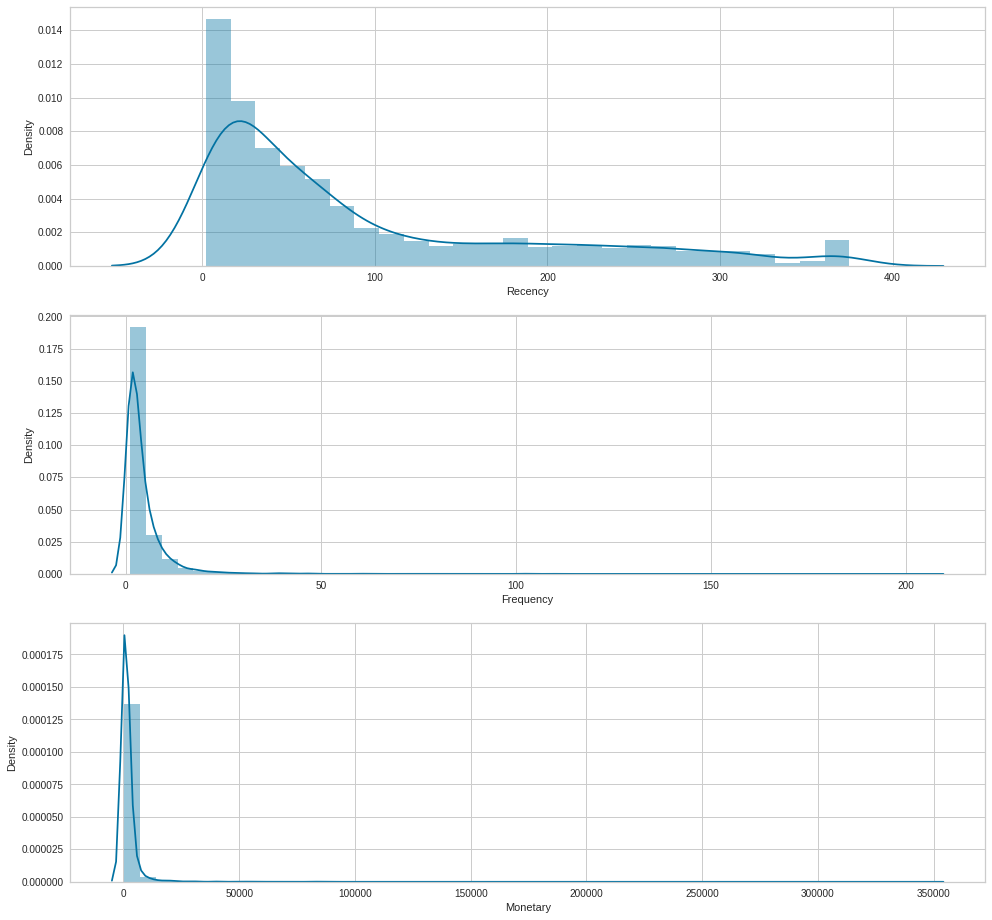

In [58]:
# standard deviation(std) is the square root of the variance, variance is the average of all data points within a group.
# mean and variance are not equal
f, ax = plt.subplots(figsize=(14, 13))
plt.subplot(3, 1, 1)
sns.distplot(rfm['Recency'], label= 'Recency')
plt.subplot(3, 1, 2)
sns.distplot(rfm['Frequency'], label= 'Frequency')
plt.subplot(3, 1, 3)
sns.distplot(rfm['Monetary'], label= 'Monetary')
plt.style.use('fivethirtyeight')
plt.tight_layout()
plt.show()

In [59]:
# UnSymmetric distribution of variables (data skewed)
# solution: Logarithmic transformation (positive values only) will manage skewness
# we use these Sequence of structuring pre-processing steps :
# 1. unskew the data - log transformation(only works with positive data)
# 2. standardize to the same average values(normalization forces data to have negative values and log will not work)
# 3. scale to the same standard deviation
# 4. store as a separate array to be used for clustering

In [60]:
# customers having more than Mean + 3 Std (Z-score > 3). will be dropped
# define frequency threshold value and drop customers who exceed the threshold
freq_stats = rfm_seg['Frequency'].describe()
freq_threshold = freq_stats['mean'] + 3 * freq_stats['std']
indx = rfm_seg.loc[rfm_seg['Frequency'] > freq_threshold].index
rfm_seg.drop(index = indx, inplace= True)

In [61]:
# define Monetary value threshold value and drop customers who exceed the threshold
m_stats = rfm_seg['Monetary'].describe()
m_threshold = m_stats['mean'] + 3 * m_stats['std']
indx = rfm_seg.loc[rfm_seg['Monetary'] > m_threshold].index
rfm_seg.drop(index = indx, inplace= True)

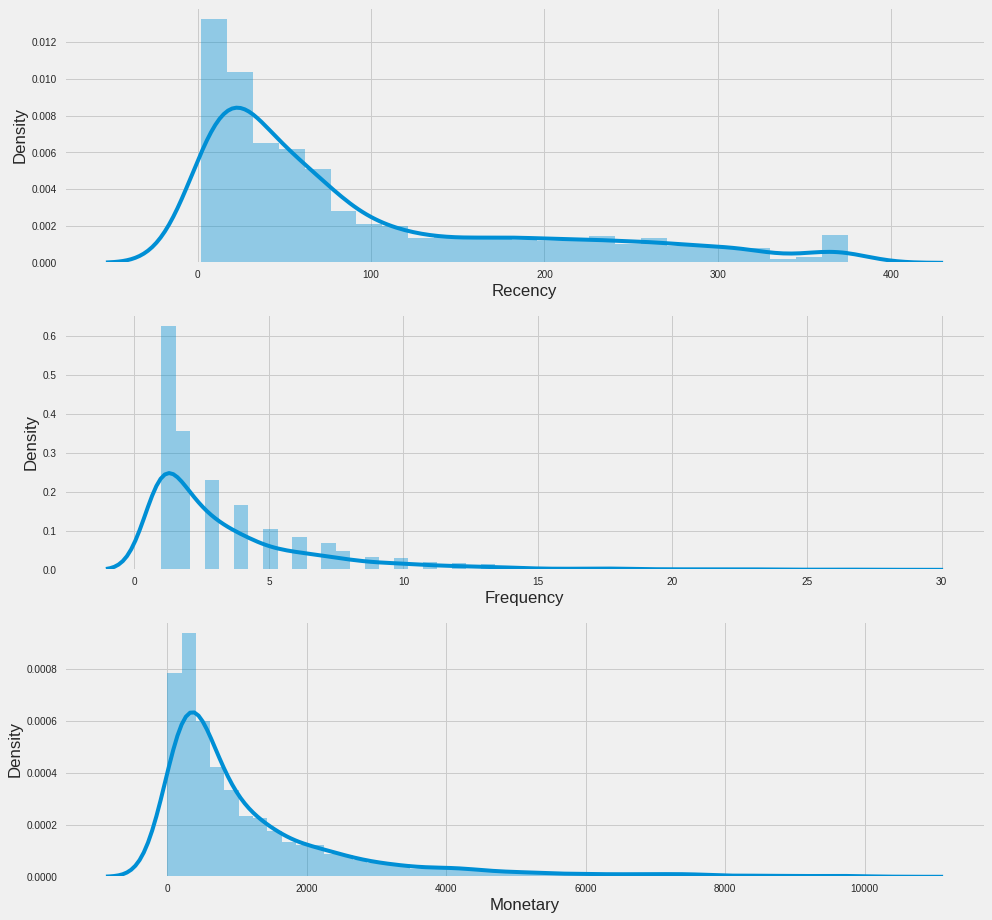

In [62]:
f, ax = plt.subplots(figsize=(14, 13))
plt.subplot(3, 1, 1)
sns.distplot(rfm_seg['Recency'], label= 'Recency')
plt.subplot(3, 1, 2)
sns.distplot(rfm_seg['Frequency'], label= 'Frequency')
plt.subplot(3, 1, 3)
sns.distplot(rfm_seg['Monetary'], label= 'Monetary')
plt.style.use('fivethirtyeight')
plt.tight_layout()
plt.show()

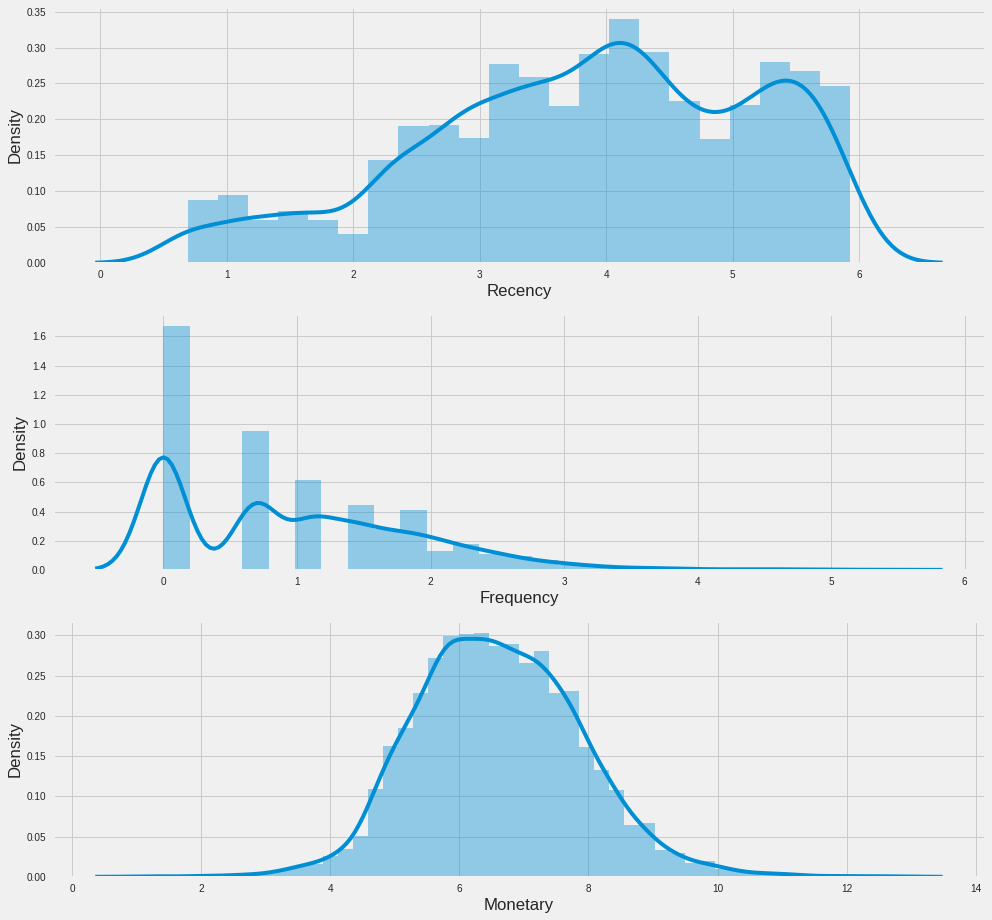

In [63]:
# unskew the data - log transformation
rfm_log = rfm[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis=1).round(3)
# rfm_log = np.log(rfm_rfm)
# plot the distribution of RFM values
f, ax = plt.subplots(figsize=(14, 13))
plt.subplot(3, 1, 1)
sns.distplot(rfm_log['Recency'], label= 'Recency')
plt.subplot(3, 1, 2)
sns.distplot(rfm_log['Frequency'], label= 'Frequency')
# type of some values monetary is category
plt.subplot(3, 1, 3)
# print(rfm_log['Monetary'].astype('category'))
# rfm_log[['Monetary']] = rfm_log[['Monetary']].apply(lambda col:pd.Categorical(col).codes)
# print(rfm_log['Monetary'] / 100)
sns.distplot(rfm_log['Monetary'] , label= 'Monetary')
plt.style.use('fivethirtyeight')
plt.tight_layout()
plt.show()

In [64]:
# method above have negative value so we don't use it for segmentation
# and just use it to compare
scaler_rfm = StandardScaler()
scaler_rfm.fit(rfm_log)
# store it separately for clustering
rfm_normalized = scaler_rfm.transform(rfm_log)
rfm_normalized_mbk = rfm_normalized.copy()
print(rfm_normalized)

[[ 0.96629064  1.56309381 -0.53305172]
 [-1.90039447 -0.31550423  0.45299823]
 [ 0.35463883 -1.07906344 -0.93618817]
 ...
 [ 1.41406594 -1.07906344 -0.42720895]
 [ 0.6700819  -0.31550423  0.43665486]
 [-0.70171078  0.44805497  0.89816048]]


In [65]:
# Monetary values range from 0 to 349164 whereas Recency and Frequency values range form 1 to a 3 digit number. By using MinMaxScaler, all the values are ranging from 0 to 1 (its default parameter).
sc = MinMaxScaler((0, 1))
df = sc.fit_transform(rfm_log)

# copy df for mini batch kmeans
df_mbk = df.copy()
df[0:5]

array([[0.84428735, 0.45049784, 0.41426248],
       [0.13240352, 0.13018974, 0.52272922],
       [0.69239587, 0.        , 0.36991696],
       [0.59056171, 0.20646252, 0.58282681],
       [0.34237677, 0.        , 0.39594213]])

In [66]:
# kmeans algorithm
# a random number of cluster is being given as a parameter for testing
kmeans = KMeans(n_clusters=4)
# kmeans = MiniBatchKMeans(n_clusters=4)
k_fit = kmeans.fit(df)

In [67]:
# centroids for the 4 clusters
k_fit.cluster_centers_

array([[0.6276529 , 0.29713178, 0.5448559 ],
       [0.87452293, 0.05655834, 0.39559185],
       [0.24374046, 0.39060735, 0.58223109],
       [0.5230943 , 0.07189858, 0.41377857]])

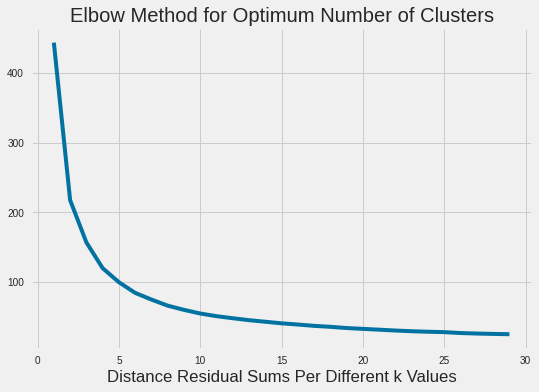

In [68]:
# elbow method will be used to determine the optimum number of clusters for rfm dataframe
kmeans = KMeans()
# kmeans = MiniBatchKMeans()
ssd = []
K = range(1, 30)

for k in K:
  kmeans = KMeans(n_clusters=k).fit(df)
  # kmeans = MiniBatchKMeans(n_clusters=k).fit(df)
  ssd.append(kmeans.inertia_)

plt.plot(K, ssd, 'bx-')
plt.xlabel('Distance Residual Sums Per Different k Values')
plt.title('Elbow Method for Optimum Number of Clusters')
plt.show()

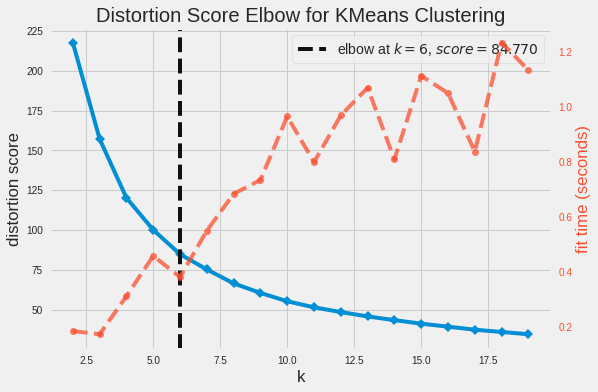

In [69]:
# make clear the number of clusters
kmeans = KMeans()
# kmeans = MiniBatchKMeans()
visu = KElbowVisualizer(kmeans, k=(2, 20))
visu.fit(df)
visu.show()

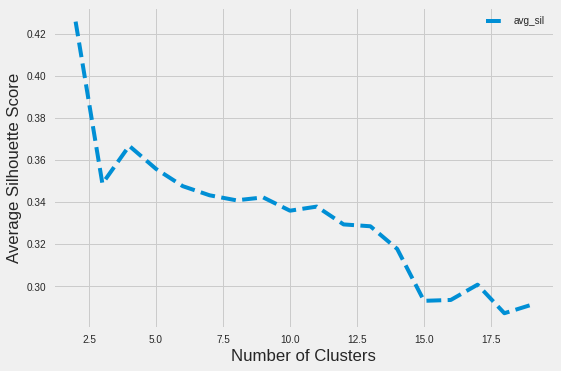

In [70]:
# make sure the number of clusters by checking with Silhouette Method
sil_avg=[]
for s in range(2, 20):
  cluster_sil = KMeans(n_clusters = s).fit_predict(df)
  silhouette_avg = silhouette_score(df, cluster_sil)
  sil_avg.append([s, silhouette_avg])

# create new array
sil_avg = np.array(sil_avg)
plt.plot(sil_avg[:, 0], sil_avg[:, 1], linestyle='dashed')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score')
plt.legend(['avg_sil'])
plt.show()

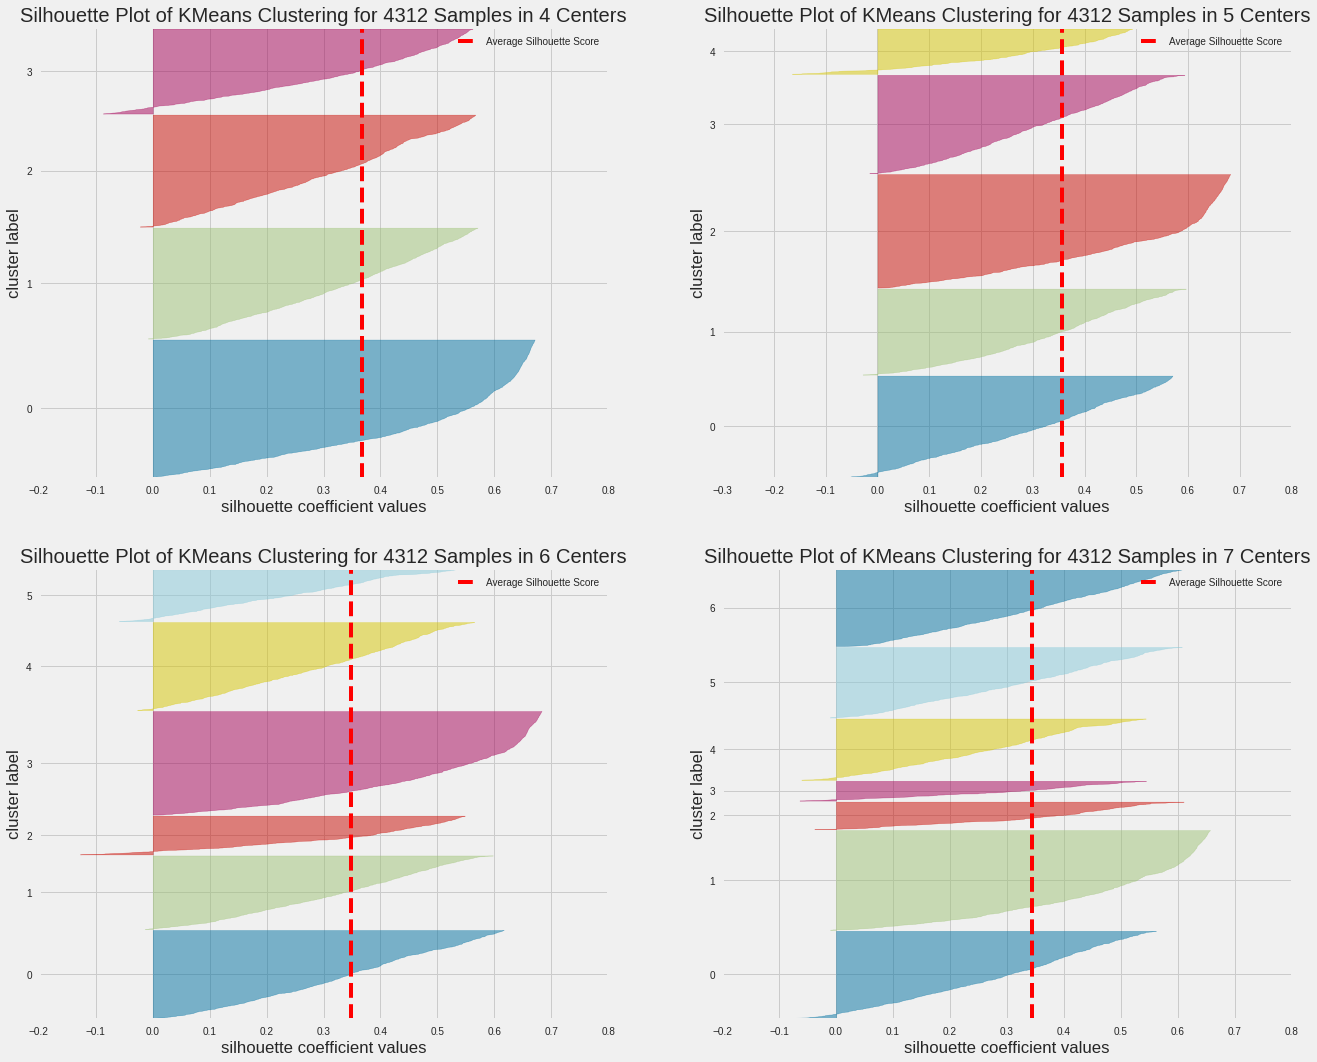

In [71]:
# average Silhouette Score from 4 to 7 clusters
fig, ax = plt.subplots(2, 2, figsize=(20,17))
axli = ax.flatten()
j = 0
for s in range(4, 8):
  cluster_silhouette = KMeans(n_clusters = s)
  visualizer = SilhouetteVisualizer(cluster_silhouette, colors='yellowbrick', ax= axli[j])
  visualizer.fit(df)
  visualizer.finalize()
  j+=1

In [72]:
%%time
# according to Elbow Method, the optimum number of cluster is 6.
# kmeans starts with allocating cluster centers randomly while kmeans++ starts with allocation one cluster center randomly and then searches for other centers given the first one.
# + 'k-means++' parameter selects initial cluster centers for k-mean clustering in a smart way to speed up convergence.
# + 'max_iter' parameter for the maximum number of iterations of the k-means algorithm for a single run. It is given in order to avoid an endless loop.
%time kmeans = KMeans(n_clusters=6, init= 'k-means++', n_init=10, random_state=0, max_iter=1000, verbose=0)
# calculate running time of kmeans
start_time = time.time()
kmeans.fit(df)
end_time = time.time() - start_time
# print(end_time)
# kmeans.fit_predict(df)
clusters = kmeans.labels_
print('\nTotal cell runtime: ', )

CPU times: user 34 µs, sys: 0 ns, total: 34 µs
Wall time: 38.9 µs

Total cell runtime: 
CPU times: user 586 ms, sys: 234 ms, total: 820 ms
Wall time: 458 ms


In [73]:
%%time
# optimized kmeans with MiniBatchKMeans algorithm
# MiniBatchKMeans algorithm on large datasets(n >= 10k observations)
# however, to get just one interation of clusterization we can use default KMeans algorithm to keep results stable. We will not observe such a dramatic improvement using MiniBatchKMeans in comparison to default KMeans algorithm one just one iteration as we have seen that on n > 1 iterations.
# it's designed to be used to find the centers approximately, not to label all points, trading speed for accuracy while k-means does not benefit much from "big data"
%time mbk = MiniBatchKMeans(n_clusters=6, init= 'k-means++', n_init=10, random_state=0, max_no_improvement=10, batch_size=100, verbose=0)
# calculate running time of MiniBatchKMeans
start_time_mbk = time.time()
# NOTE : reduce memory usage for big dataset, let you update the model with incremental data when the whole dataset cannot be loaded into the memory
# partial_fit is for online clustering were fit is for offline
# partial_fit update k means estimate on a single mini-batch
mbk.partial_fit(df_mbk)
# mbk.fit(df_mbk)
end_time_mbk = time.time() - start_time_mbk
# print(end_time_mbk)
clusters_mbk = mbk.labels_
print('\nTotal cell runtime: ', )

CPU times: user 68 µs, sys: 14 µs, total: 82 µs
Wall time: 45.1 µs

Total cell runtime: 
CPU times: user 9.65 ms, sys: 3.39 ms, total: 13 ms
Wall time: 9.58 ms


In [74]:
# segment labels for the first 30 customers
print(clusters[0:50])
print(clusters_mbk[0:50])

[0 3 4 0 3 3 4 2 1 1 3 0 1 0 2 2 2 0 2 0 2 0 4 3 2 4 0 3 3 4 0 0 0 2 3 3 2
 3 4 1 2 2 1 1 0 2 4 0 4 0]
[0 1 3 0 4 4 4 2 1 0 1 0 1 3 2 2 2 0 3 0 2 0 4 4 2 0 0 4 4 4 3 0 0 2 4 1 2
 0 4 0 2 2 0 0 0 2 4 0 4 3]


In [75]:
# customer id and the segment numbers with kmeans
pd.DataFrame({'Customer ID': rfm.index, 'Clusters': clusters})

,Customer ID,Clusters
0,12346.00000,0
1,12347.00000,3
2,12348.00000,4
3,12349.00000,0
4,12351.00000,3
...,...,...
4307,18283.00000,1
4308,18284.00000,4
4309,18285.00000,2
4310,18286.00000,0


In [76]:
# customer id and the segment numbers with MiniBatchKMeans
pd.DataFrame({'Customer ID': rfm_mbk.index, 'Clusters': clusters_mbk})

,Customer ID,Clusters
0,12346.00000,0
1,12347.00000,1
2,12348.00000,3
3,12349.00000,0
4,12351.00000,4
...,...,...
4307,18283.00000,1
4308,18284.00000,3
4309,18285.00000,2
4310,18286.00000,3


In [77]:
# options 1 with kmeans
# add cluster numbers as a variable to rfm dataframe
# add 1 to cluster segment number so that it starts with 1 instead of 0
rfm['Cluster'] = clusters
rfm['Cluster'] = rfm['Cluster'] + 1
rfm.groupby('Cluster').agg({'Cluster':'count'})

,Cluster
Cluster,
1,854
2,715
3,1008
4,504
5,854
6,377


In [78]:
# options 2 with MiniBatchKMeans
# add cluster numbers as a variable to rfm dataframe
# add 1 to cluster segment number so that it starts with 1 instead of 0
rfm_mbk['Cluster'] = clusters_mbk
rfm_mbk['Cluster'] = rfm_mbk['Cluster'] + 1
rfm_mbk.groupby('Cluster').agg({'Cluster':'count'})

,Cluster
Cluster,
1,982
2,651
3,803
4,872
5,645
6,359


In [79]:
# options 1 with kmeans
rfm.head(15)

,Recency,Frequency,Monetary,Cluster
Customer ID,,,,
12346.00000,166,11,372.86000,1
12347.00000,4,2,1323.32000,4
12348.00000,75,1,222.16000,5
12349.00000,44,3,2671.14000,1
12351.00000,12,1,300.93000,4
12352.00000,12,2,343.80000,4
12353.00000,45,1,317.76000,5
12355.00000,204,1,488.21000,3
12356.00000,17,3,3560.30000,2


In [80]:
# options 2 with MiniBatchKMeans
rfm_mbk.head(15)

,Recency,Frequency,Monetary,Cluster
Customer ID,,,,
12346.00000,166,11,372.86000,1
12347.00000,4,2,1323.32000,2
12348.00000,75,1,222.16000,4
12349.00000,44,3,2671.14000,1
12351.00000,12,1,300.93000,5
12352.00000,12,2,343.80000,5
12353.00000,45,1,317.76000,5
12355.00000,204,1,488.21000,3
12356.00000,17,3,3560.30000,2


In [81]:
# calculate average RFM values and size for each cluster
rfm_rfms = rfm_rfm.copy()
rfm_rfm_kmeans = rfm_rfm.assign(Clusters= clusters + 1)
rfm_rfm_mbk = rfm_rfms.assign(Clusters= clusters_mbk + 1)

print(rfm_rfm_kmeans.groupby('Clusters').agg({'Recency': 'mean','Frequency': 'mean', 'Monetary': ['mean', 'count']}).round(0))
print(rfm_rfm_mbk.groupby('Clusters').agg({'Recency': 'mean','Frequency': 'mean', 'Monetary': ['mean', 'count']}).round(0))

           Recency Frequency    Monetary      
              mean      mean        mean count
Clusters                                      
1         99.00000   4.00000  1813.00000   854
2         25.00000   8.00000  3182.00000   715
3        238.00000   1.00000   370.00000  1008
4         13.00000   2.00000   664.00000   504
5         53.00000   1.00000   430.00000   854
6          5.00000  17.00000 10345.00000   377
           Recency Frequency    Monetary      
              mean      mean        mean count
Clusters                                      
1         59.00000   4.00000  1909.00000   982
2          9.00000   6.00000  2218.00000   651
3        254.00000   1.00000   311.00000   803
4        121.00000   2.00000   674.00000   872
5         26.00000   1.00000   428.00000   645
6         20.00000  20.00000 12163.00000   359


In [82]:
# snake plots to understand and compare segments
rfm_normalized = pd.DataFrame(rfm_normalized, index=rfm_rfm.index, columns=rfm_rfm.columns)
rfm_normalized['Clusters'] = clusters + 1
rfm_normalized['General_Segment'] = rfm_seg['General_Segment']
rfm_normalized.reset_index(inplace= True)

rfm_melt = pd.melt(rfm_normalized, id_vars=['Customer ID','General_Segment','Clusters'],value_vars=['Recency', 'Frequency', 'Monetary'], var_name='Metric',value_name='Value')
rfm_melt.head()

,Customer ID,General_Segment,Clusters,Metric,Value
0,12346.00000,Silver,1,Recency,0.96629
1,12347.00000,Gold,4,Recency,-1.90039
2,12348.00000,Iron,5,Recency,0.35464
3,12349.00000,Gold,1,Recency,-0.05544
4,12351.00000,Bronze,4,Recency,-1.05485


In [83]:
# snake plots for mini batch kmeans
rfm_normalized_mbk = pd.DataFrame(rfm_normalized_mbk, index=rfm_rfms.index, columns=rfm_rfms.columns)
rfm_normalized_mbk['Clusters'] = clusters_mbk + 1
rfm_normalized_mbk['General_Segment'] = rfm_seg['General_Segment']
rfm_normalized_mbk.reset_index(inplace= True)

rfm_melt_mbk = pd.melt(rfm_normalized_mbk, id_vars=['Customer ID', 'General_Segment', 'Clusters'], value_vars=['Recency', 'Frequency', 'Monetary'], var_name= 'Metric', value_name='Value')
rfm_melt_mbk.head()

,Customer ID,General_Segment,Clusters,Metric,Value
0,12346.00000,Silver,1,Recency,0.96629
1,12347.00000,Gold,2,Recency,-1.90039
2,12348.00000,Iron,4,Recency,0.35464
3,12349.00000,Gold,1,Recency,-0.05544
4,12351.00000,Bronze,5,Recency,-1.05485


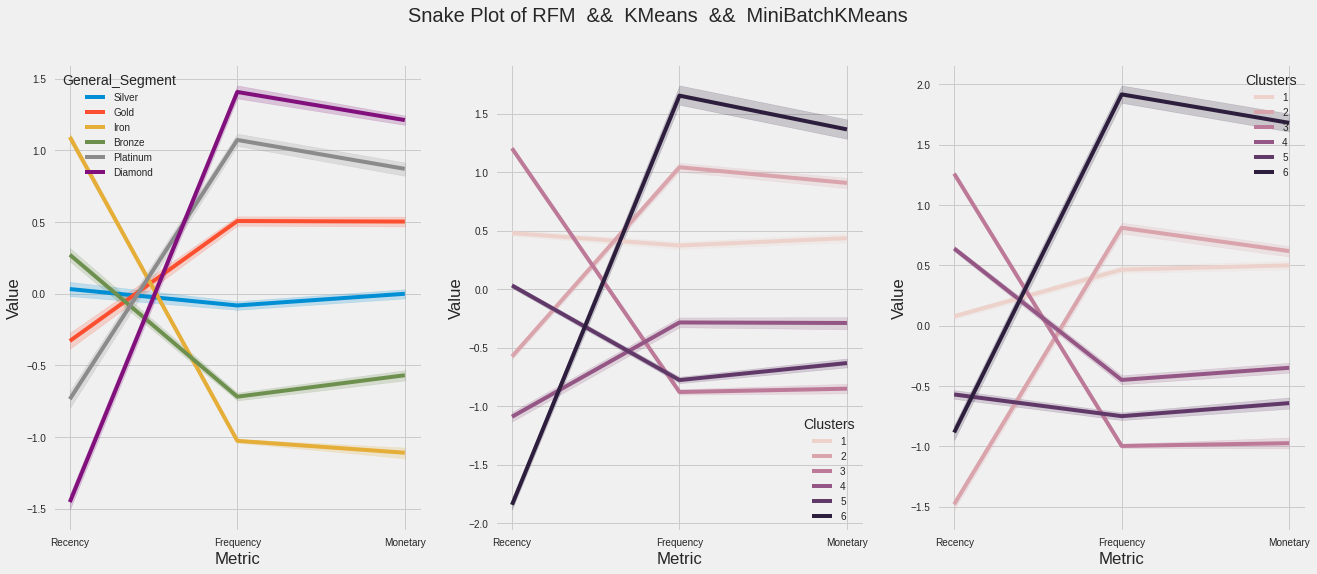

In [84]:
# snake plot
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))
sns.lineplot(x= 'Metric', y= 'Value', hue= 'General_Segment', data= rfm_melt, ax=ax1)
sns.lineplot(x = 'Metric', y = 'Value', hue = 'Clusters', data = rfm_melt, ax=ax2)
sns.lineplot(x = 'Metric', y = 'Value', hue = 'Clusters', data = rfm_melt_mbk, ax=ax3)
plt.suptitle('Snake Plot of RFM  &&  KMeans  &&  MiniBatchKMeans', fontsize=20)
plt.show()

In [85]:
# useful technique to identify relative importance of each segment's attribute
# calculate average values of each cluster and average values of population
# calculate importance score by dividing them and subtracting 1 (ensures 0 is returned when cluster average equals population average)

In [86]:
# scaled data to standardize with 3 attributes and show in 
# scaler = StandardScaler()
# scaler_mbk = StandardScaler()

kmeans_3 = rfm[['Recency',	'Frequency', 'Monetary']]
mbk_3 = rfm_mbk[['Recency',	'Frequency', 'Monetary']]

kmeans_3['Recency'] = df[:,0]
kmeans_3['Frequency'] = df[:,1]
kmeans_3['Monetary'] = df[:,2]

mbk_3['Recency'] = df_mbk[:,0]
mbk_3['Frequency'] = df_mbk[:,1]
mbk_3['Monetary'] = df_mbk[:,2]

# scaler.fit(kmeans_3)
# scaler_mbk.fit(mbk_3)

# kmeans_scaled = scaler.transform(kmeans_3)
# mbk_scaled = scaler_mbk.transform(mbk_3)

# print(kmeans_scaled)
# print(mbk_scaled)

# scaled cluster center too
# kmeans.cluster_centers_ = scaler.fit_transform(kmeans.cluster_centers_)
# mbk.cluster_centers_ = scaler_mbk.fit_transform(mbk.cluster_centers_)


In [87]:
# 3d version of kmeans
fig_3d_kmeans = px.scatter_3d(
    kmeans_3,
    x= 'Recency',
    y= 'Frequency', 
    z= 'Monetary', 
    color= (clusters + 1).astype(str),
    opacity= 0.7,
    height= 650,
    width= 700,
    title= 'Clusters Obtained using KMeans<br><sup>Training time: %.3fs & Inertia: %f</sup>' % (end_time, kmeans.inertia_),
    color_discrete_sequence = px.colors.qualitative.Set2
)
fig_3d_kmeans.show()

In [88]:
# 3d version of Mini Batch Kmeans
fig_3d_mbk = px.scatter_3d(
    mbk_3,
    x= 'Recency', 
    y= 'Frequency', 
    z= 'Monetary', 
    color= (clusters_mbk + 1).astype(str),
    opacity= 0.7,
    height= 650,
    width= 700,
    title= 'Clusters Obtained using Mini Batch Kmeans<br><sup>Training time: %.3fs & Inertia: %f</sup>' % (end_time_mbk, mbk.inertia_),
    color_discrete_sequence = px.colors.qualitative.Set2
)
fig_3d_mbk.show()

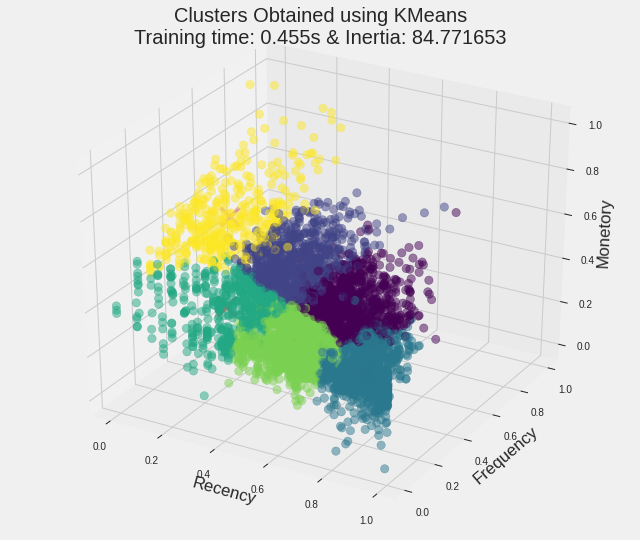

In [89]:
# create 3D chart compare 2 options
# first for kmeans algorithm
fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(projection='3d')

ax.scatter(df[:,0], df[:,1], df[:,2], c= clusters, cmap= 'viridis', s= 70, alpha= 0.5)
ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,2], s = 350, c = 'r', marker='x', edgecolor='k', label = 'Centroid')
  
plt.title('Clusters Obtained using KMeans\nTraining time: %.3fs & Inertia: %f' % (end_time, kmeans.inertia_),fontsize = 20)
ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetory")
plt.autoscale(enable=True, axis='x', tight=True)
kmeansImage = plt.savefig('Kmeans.png', bbox_inches='tight')
plt.show()
plt.close(fig)

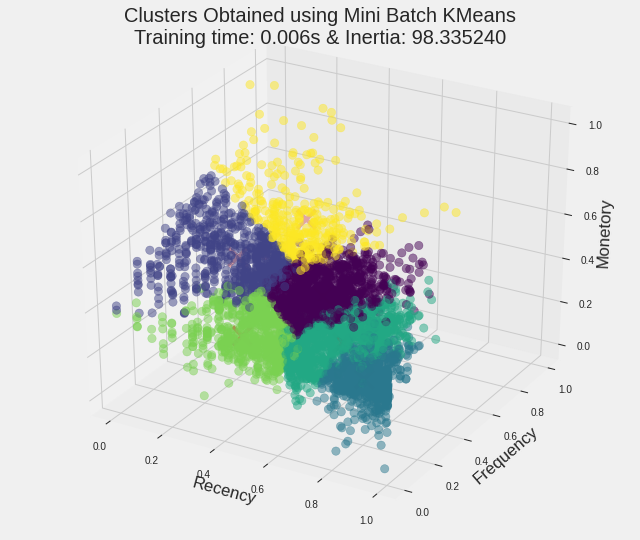

In [90]:
# create 3D chart compare 2 options
# second for Mini Batch Kmeans
fig_mbk = plt.figure(figsize=(10, 9))
ax_mbk = fig_mbk.add_subplot(projection='3d')

ax_mbk.scatter(df[:,0], df[:,1], df[:,2], c= clusters_mbk, cmap= 'viridis', s= 70, alpha= 0.5)
ax_mbk.scatter(mbk.cluster_centers_[:,0], mbk.cluster_centers_[:,1], mbk.cluster_centers_[:,2], s = 350, c = 'r', marker='x', edgecolor='k', label = 'Centroid')

plt.title('Clusters Obtained using Mini Batch KMeans\nTraining time: %.3fs & Inertia: %f' % (end_time_mbk, mbk.inertia_), fontsize = 20)
ax_mbk.set_xlabel("Recency")
ax_mbk.set_ylabel("Frequency")
ax_mbk.set_zlabel("Monetory")
plt.autoscale(enable=True, axis='x', tight=True)
mbkImage = plt.savefig('MiniBatchKmeans.png', bbox_inches='tight')
plt.show()
plt.close(fig_mbk)

In [91]:
# show and compare final result image
# inertia is the sum of squared distances of samples to their closest cluster center
imageKmeans = widgets.Image(value=open('Kmeans.png', 'rb').read())
imageMiniBatchKmeans = widgets.Image(value=open('MiniBatchKmeans.png', 'rb').read())
hbox = HBox([imageKmeans, imageMiniBatchKmeans])
display(hbox)

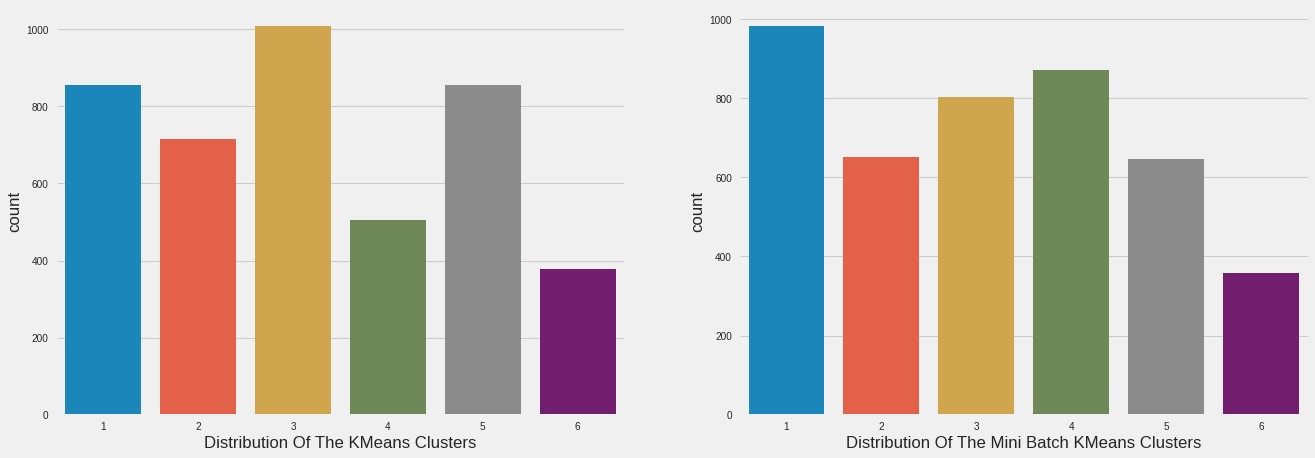

In [92]:
# distribution of customers
df_dis = pd.DataFrame()
df_dis['Distribution Of The KMeans Clusters']= rfm["Cluster"]
df_dis['Distribution Of The Mini Batch KMeans Clusters']= rfm_mbk["Cluster"]


fig, ax =plt.subplots(1,2, figsize=(20,7))
sns.countplot(df_dis['Distribution Of The KMeans Clusters'], ax=ax[0])
sns.countplot(df_dis['Distribution Of The Mini Batch KMeans Clusters'], ax=ax[1])
fig.show()

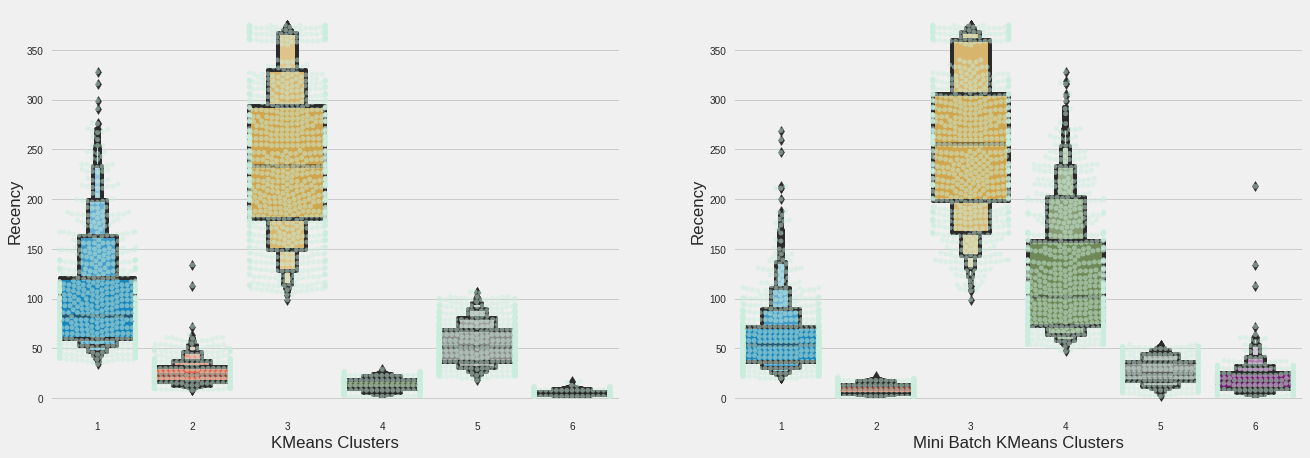

In [93]:
# recency each clusters
df_re = pd.DataFrame()
df_re['KMeans Clusters']= rfm["Cluster"]
df_re['Mini Batch KMeans Clusters']= rfm_mbk["Cluster"]


fig, (ax1, ax2)=plt.subplots(1,2, figsize=(20,7))
sns.swarmplot(x=df_re['KMeans Clusters'], y=rfm['Recency'], color= "#CBEDDD", alpha=0.5, ax=ax1)
sns.boxenplot(x=df_re['KMeans Clusters'], y=rfm['Recency'], ax=ax1)

sns.swarmplot(x=df_re['Mini Batch KMeans Clusters'], y=rfm_mbk['Recency'], color= "#CBEDDD", alpha=0.5, ax=ax2)
sns.boxenplot(x=df_re['Mini Batch KMeans Clusters'], y=rfm_mbk['Recency'], ax=ax2)
fig.show()

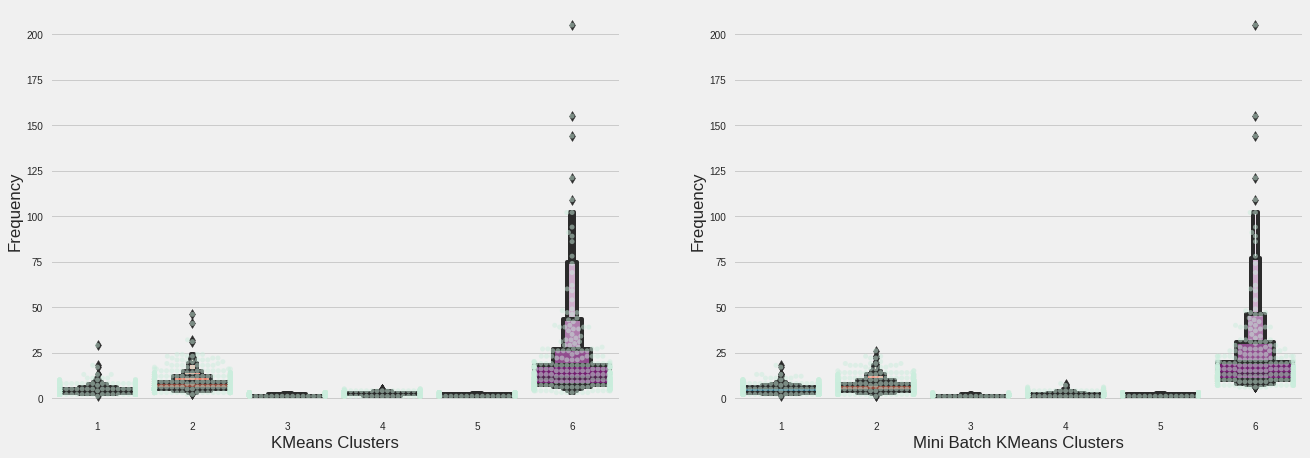

In [94]:
# frequency each clusters
df_fre = pd.DataFrame()
df_fre['KMeans Clusters']= rfm["Cluster"]
df_fre['Mini Batch KMeans Clusters']= rfm_mbk["Cluster"]


fig, (ax1, ax2)=plt.subplots(1,2, figsize=(20,7))
sns.swarmplot(x=df_fre['KMeans Clusters'], y=rfm['Frequency'], color= "#CBEDDD", alpha=0.5, ax=ax1)
sns.boxenplot(x=df_fre['KMeans Clusters'], y=rfm['Frequency'], ax=ax1)

sns.swarmplot(x=df_fre['Mini Batch KMeans Clusters'], y=rfm_mbk['Frequency'], color= "#CBEDDD", alpha=0.5, ax=ax2)
sns.boxenplot(x=df_fre['Mini Batch KMeans Clusters'], y=rfm_mbk['Frequency'], ax=ax2)
fig.show()

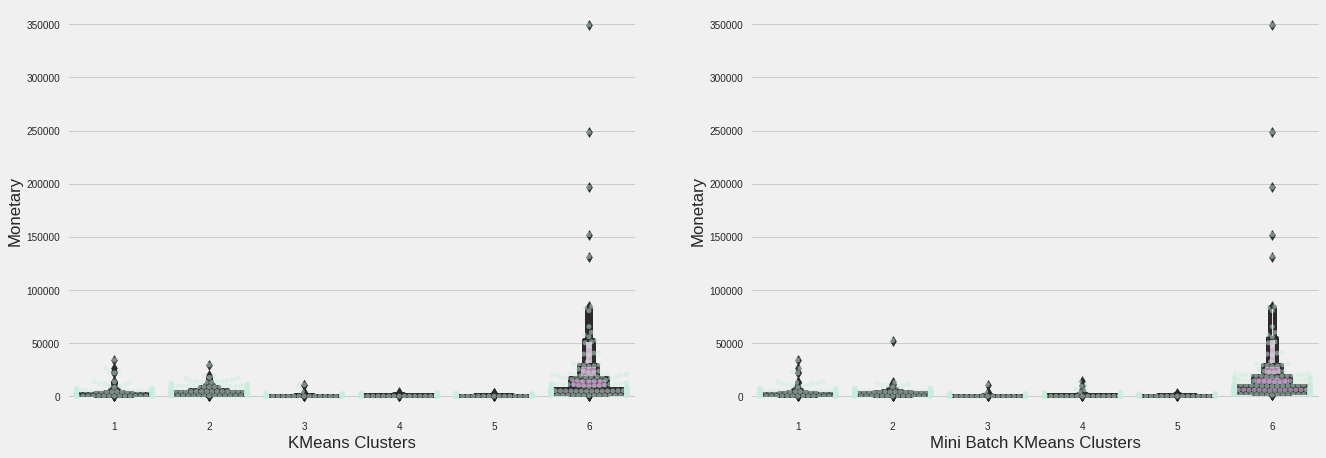

In [95]:
# monetary each clusters
df_mon = pd.DataFrame()
df_mon['KMeans Clusters']= rfm["Cluster"]
df_mon['Mini Batch KMeans Clusters']= rfm_mbk["Cluster"]


fig, (ax1, ax2)=plt.subplots(1,2, figsize=(20,7))
sns.swarmplot(x=df_mon['KMeans Clusters'], y=rfm['Monetary'], color= "#CBEDDD", alpha=0.5, ax=ax1)
sns.boxenplot(x=df_mon['KMeans Clusters'], y=rfm['Monetary'], ax=ax1)

sns.swarmplot(x=df_mon['Mini Batch KMeans Clusters'], y=rfm_mbk['Monetary'], color= "#CBEDDD", alpha=0.5, ax=ax2)
sns.boxenplot(x=df_mon['Mini Batch KMeans Clusters'], y=rfm_mbk['Monetary'], ax=ax2)
fig.show()

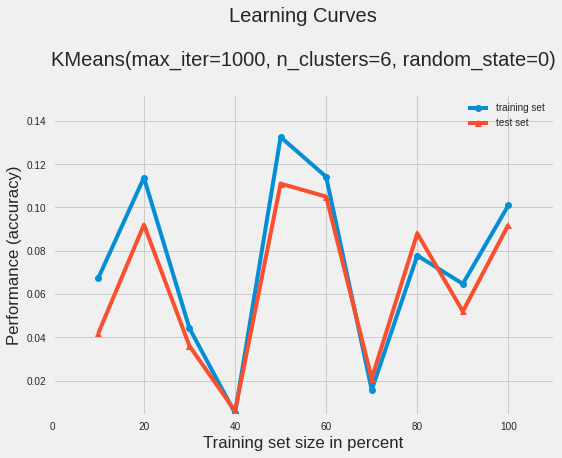

In [96]:
# sample data for training learning curve kmeans
X, y = mnist_data()
X, y = shuffle_arrays_unison(arrays=[X, y], random_seed=123)
X_train, X_test = X[:4000], X[4000:]
y_train, y_test = y[:4000], y[4000:]
plot_learning_curves(X_train, y_train, X_test, y_test, kmeans, scoring='accuracy', style='fast')
kmeansImage = plt.savefig('KmeansLearningCurve.png', bbox_inches='tight')
plt.show()
plt.close()

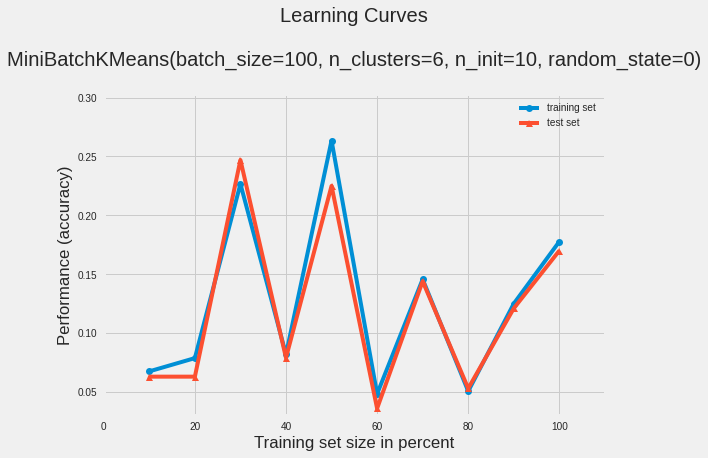

In [97]:
# sample data for training learning curve mini batch kmeans
X, y = mnist_data()
X, y = shuffle_arrays_unison(arrays=[X, y], random_seed=123)
X_train, X_test = X[:4000], X[4000:]
y_train, y_test = y[:4000], y[4000:]
plot_learning_curves(X_train, y_train, X_test, y_test, mbk, scoring='accuracy', style='fast')
mbkImage = plt.savefig('MiniBatchKmeansLearningCurve.png', bbox_inches='tight')
plt.show()
plt.close()

In [98]:
# show and compare final result image of learning curve
imageKmeansLearningCurve = widgets.Image(value=open('KmeansLearningCurve.png', 'rb').read())
imageMiniBatchKmeansLearningCurve = widgets.Image(value=open('MiniBatchKmeansLearningCurve.png', 'rb').read())
hbox_curve = HBox([imageKmeansLearningCurve, imageMiniBatchKmeansLearningCurve])
display(hbox_curve)

In [99]:
# convert demo to pdf
!jupyter nbconvert --to html /content/MainProject.ipynb

[NbConvertApp] Converting notebook /content/MainProject.ipynb to html
[NbConvertApp] Writing 3109595 bytes to /content/MainProject.html
